# Brand Insights for SecretLab

### Problem statement:
Scraping youtube comments to gather topical insights and information that would help Secretlab and their content creators amplify the Seecretlab brand. 

### Executive Summary:
Since its launch in 2005, YouTube has quickly become the largest video sharing platform on the Internet. As of the year 2016, YouTube has reported more than a billion users with over 300 hours of video uploaded every minute. However, as with other forms of social media, a mountain of insights can be obtained through video analytics and the comments to a brand understand how their consumers are interacting with their products and/or services.

Our main objective is to help Secretlab effectively understand the needs and concerns of their viewers, thus respond faster to these concerns and deliver higher-quality content. These insights could be shared with content creators when representing Secretlab, as part of the media kit. A dataset of 9480 comments sampled from 184 YouTube videos were used to conduct our analysis.


### Insights and recommendation:
    * The EDA provided valuable insights from the video statistics that would help content creators in boosting the Secretlab brand, for eg. the time/day to post up content based on engagement, the optimal duration of their video
    * Explored the Youtube marketing efforts between the launch of the 2018 series and the 2020 series
    * Looked at the effect the length of the comment had on its engagement
    * Identified top 3 content creators under the Super, Micro and Nano Influencer categories that Secretlab could potentially collaborate with
    * Explored the response time of between comments and replies
    * Suggested top 5 keywords that content creators could add to their video tags and improve the SEO of their video
    * Analysed key trigger words that viewers associated with the Secretlab brand in their comments
    * Using LDA, clustered the comments into top 6 topics
    * Using Doc2Vec and Logistic Regression, created a comment classifier that could be utilised to tag new incoming comments and extract specific product feature feedback

<br></br>
***Future Recommendation:***
1. There is a considerable amount of noise in the corpus due to the presence of comments unrelated to the brand but rather directed at the content creator or other details. A Spam/ham classifier could be built to understand and weed out these irrelevant comments to improve the final model's accuracy.
2. Currently, we are only using the dominant topic as the document id but we could potentially pass in the top 3 topics to improve the semantic understanding of each comment and aid in a better classification between topics.  


# Data Collection

Making 3 api calls using Youtube API V3:

     1.Search
            * To extract the list of video_ids that are related to the Secretlab brand
            * The raw results should not be used and some processing is required to weed out videos that might be talking 
            about competitors, board game with similar name, not in english.
     2. Videos
             * Extract all the video stats from the identified video_ids
             * Saved as "videostats.csv"
     3. CommentThreads
             * Extract the comments and corresponding replies
             * Saved as "videocomments.csv"
           

In [435]:
#importing all libraries for EDA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
import re
import time, datetime, calendar

from scipy.stats import ttest_ind
from scipy.stats import spearmanr

%matplotlib inline

import warnings;
warnings.filterwarnings('ignore');

# Video Statistics section
 
From our API call, we have extracted the statistics of each video and will explore the relationships between the various content creators and their videos.

In [290]:
stats = pd.read_csv('vidstats.csv')

In [291]:
stats.info()
stats.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   video_id        184 non-null    object 
 1   video_date      184 non-null    object 
 2   video_title     184 non-null    object 
 3   video_author    184 non-null    object 
 4   video_tags      167 non-null    object 
 5   video_duration  184 non-null    object 
 6   viewCount       184 non-null    int64  
 7   likeCount       183 non-null    float64
 8   dislikeCount    183 non-null    float64
 9   favoriteCount   184 non-null    int64  
 10  commentCount    184 non-null    int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 15.9+ KB


,video_id,video_date,video_title,video_author,video_tags,video_duration,viewCount,likeCount,dislikeCount,favoriteCount,commentCount
0,31glAeRYkD4,2019-11-28 18:15:00+00:00,Secretlab Titan Review - An Honest Opinion...,Stu’s Reviews,"secret lab chair,secret lab titan 2020,secret lab review,secret lab titan review,secret lab chai...",0:11:43,142233,2669.0,140.0,0,533
1,cLBGKqcqJmg,2020-05-07 19:07:41+00:00,Secretlab Titan Review - 9 Months Later...,Stu’s Reviews,"secretlab titan review,secretlab titan 2020 review,secretlab honest review,secretlab review,tita...",0:16:01,207093,6347.0,400.0,0,902
2,1YS-mFoTK5c,2020-07-03 19:42:28+00:00,Secretlab Titan 2020 Review: Worth $400?,Tech Audit TV,"gaming chair,gaming chair review,best gaming chair,quality gaming chair,pro gaming chair,secretl...",0:08:16,49704,1452.0,34.0,0,297
3,gGQtbDKmd3M,2018-10-29 19:11:33+00:00,The Remastered SecretLab OMEGA Gaming Chair - Comprehensive Review,Mike Wat,"secret lab omega,secret lab discount code,secret lab gaming chair,secret lab review,secret lab c...",0:12:52,187654,3356.0,325.0,0,788
4,6eyQGn5Df4k,2018-10-30 23:07:41+00:00,"Secretlab Titan Review Update: 8 Months Later, Is it Still Worth It?",Tech Guided,"secretlab,titan,secretlab titan,gaming chair,secretlab titan review,pc gaming chair,review,gamer...",0:06:48,322907,2432.0,104.0,0,570


##### There are some null values in the video tags column, and there is one video that has null values for both like and dislike counts. Let's zoom into that video

In [294]:
stats[stats.likeCount.isnull()]

,video_id,video_date,video_title,video_author,video_tags,video_duration,viewCount,likeCount,dislikeCount,favoriteCount,commentCount
34,qvnR4BChZjQ,2019-01-16 03:40:36+00:00,SECRETLAB OMEGA AND THRONE SOFTWEAVE FABRIC REVIEW | VLOG 09,Andy Xu,"secretlab,secret lab,secretlab omega,secretlab throne,omega review,throne review,secretlab omega...",2020-10-14 00:09:55,6042,NaN,NaN,0,60


#### It seems that the video is not an anomaly and has a decent number of views, the content creator should look into asking for some engagement during his video

In [298]:
# update Dtypes to the respective formats

stats.video_date = pd.to_datetime(stats.video_date, errors='coerce')
stats.video_duration = pd.to_datetime(stats.video_duration, errors='coerce')
stats.likeCount.fillna(0, inplace=True)
stats.dislikeCount.fillna(0, inplace=True)
stats.likeCount = stats.likeCount.astype('int')
stats.dislikeCount= stats.dislikeCount.astype('int')
stats.drop(columns=['favoriteCount'], inplace=True)
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   video_id        184 non-null    object             
 1   video_date      184 non-null    datetime64[ns, UTC]
 2   video_title     184 non-null    object             
 3   video_author    184 non-null    object             
 4   video_tags      167 non-null    object             
 5   video_duration  184 non-null    datetime64[ns]     
 6   viewCount       184 non-null    int64              
 7   likeCount       184 non-null    int64              
 8   dislikeCount    184 non-null    int64              
 9   commentCount    184 non-null    int64              
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), int64(4), object(4)
memory usage: 14.5+ KB


In [299]:
stats.describe().T

,count,mean,std,min,25%,50%,75%,max
viewCount,184.0,102049.342391,949648.801012,32.0,537.5,3927.5,24712.75,12859154.0
likeCount,184.0,442.304348,1074.833989,0.0,11.0,57.0,319.00,8443.0
dislikeCount,184.0,29.831522,75.363664,0.0,1.0,6.0,23.50,656.0
commentCount,184.0,99.489130,178.580682,0.0,6.0,30.0,103.75,1131.0


##### There seems to be overall positive sentiment to the videos considering that there are more likes than dislikes across all videos

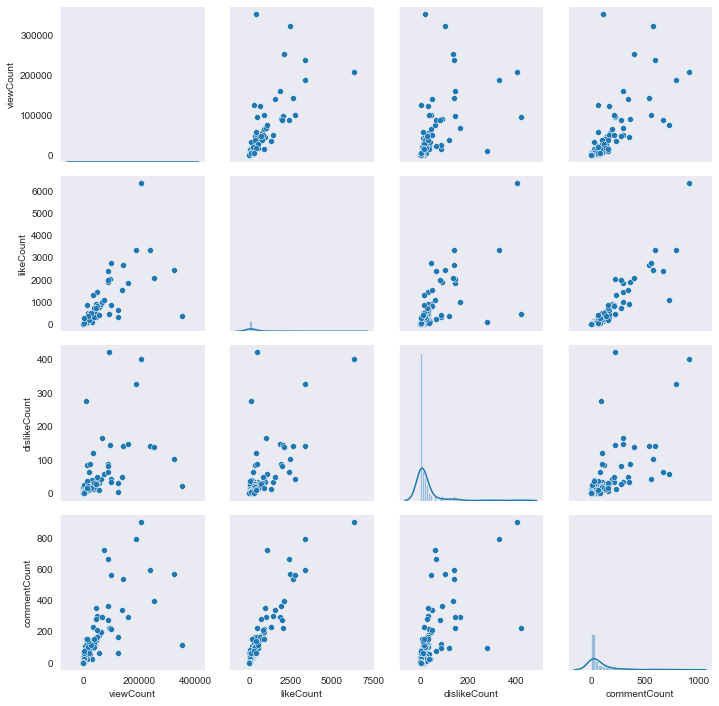

In [313]:
g = sns.PairGrid(stats[(stats.viewCount < 5e5) & (stats.likeCount != stats.likeCount.max()) &
                       (stats.dislikeCount != stats.dislikeCount.max()) & (stats.commentCount != stats.commentCount.max())])
g.map_diag(sns.distplot)
g.map_offdiag(sns.scatterplot);

### The distributions for the like,dislike,view,comment counts are all positively correlated but let's explore if their relationships have statistical significance

### We can conclude that the distributions of number of comments and views have greater similarity than likes/dislikes, after a p-test

In [431]:
print("Comparing between Comments and Dislikes\n")
stat, p = ttest_ind(stats.commentCount, stats.dislikeCount)
print(f'stat={stat:.3}, p={p:.3}')
if p > 0.05:
    print(f'\n--> Probably having similar distributions')
else:
    print('\n--> The difference in the distributions are significant')

Comparing between Comments and Dislikes

stat=4.87, p=1.63e-06

--> The difference in the distributions are significant


In [432]:
print("Comparing between Comments and Likes\n")
stat, p = ttest_ind(stats.commentCount, stats.likeCount)
print(f'stat={stat:.3}, p={p:.3}')
if p > 0.05:
    print(f'\n--> Probably having similar distributions')
else:
    print('\n--> The difference in the distributions are significant')

Comparing between Comments and Likes

stat=-4.27, p=2.52e-05

--> The difference in the distributions are significant


In [433]:
print("Comparing between Comments and Views\n")
stat, p = ttest_ind(stats.commentCount, stats.viewCount)
print(f'stat={stat:.3}, p={p:.3}')
if p > 0.05:
    print(f'\n--> Probably having similar distributions')
else:
    print('\n--> The difference in the distributions are significant')

Comparing between Comments and Views

stat=-1.46, p=0.146

--> Probably having similar distributions


#### Plotting the video duration vs the average view count, we can observe the following:
* The average duration of the videos is 6 min, with approx 40k views
* To maximise the number of views, content creators could potentially look at creating videos betweeen 16-21 mins
* Having videos longer than 21 mins, tend to drop in viewership count

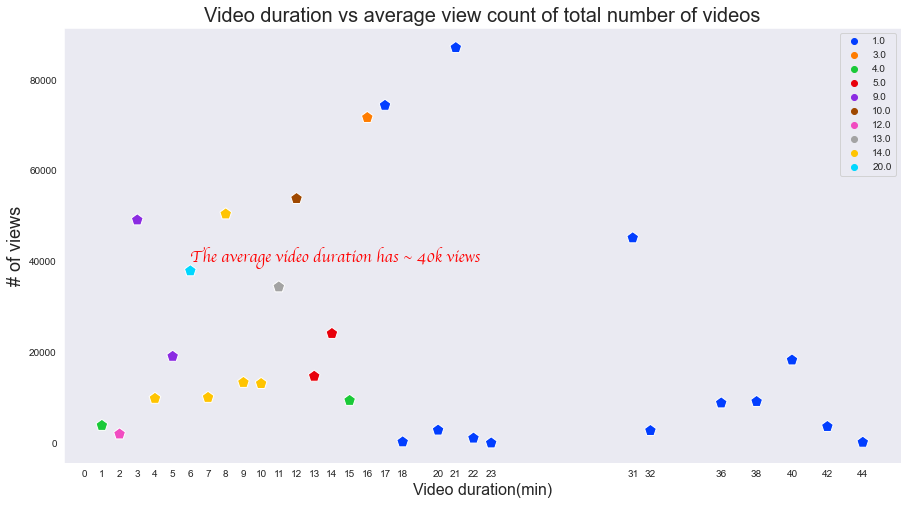

In [314]:
vid_dur_viewct = stats.groupby(stats.video_duration.dt.minute)['viewCount'].agg(['count','mean'])
labels = [x for x in vid_dur_viewct[:].index]

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_axes()
sns.scatterplot(vid_dur_viewct[1:].index, vid_dur_viewct.values[1:,1],ax=ax1,hue=vid_dur_viewct.values[1:,0],palette='bright',s=150, marker='p');
plt.xticks(labels)
plt.xlabel('Video duration(min)', fontsize=16)
plt.ylabel('# of views', fontsize=18);
plt.text(6,40000,"The average video duration has ~ 40k views", fontfamily=('cursive'), fontsize=16, color='r')
plt.title("Video duration vs average view count of total number of videos", fontsize=20);

### The videos with a duration of lower than a minute were removed from the plot above as their view counts were astronomical. Taking a closer look at those videos revealed that most were video ads by Secretlab itself.

In [15]:
stats[stats.video_duration.dt.minute < 1]

,video_id,video_date,video_title,video_author,video_tags,video_duration,viewCount,likeCount,dislikeCount,commentCount
44,1zvv9e-_s1Y,2016-08-15 04:23:30+00:00,Secretlab's OMEGA (PRODUCT REVIEW),TECH360.TV,"secretlab,secret lab,secretlab omega,secret la...",2020-10-13 00:00:59,4963,8,14,0
100,Ap2N6BK5Xlo,2019-11-26 03:25:43+00:00,"Secretlab TITAN XL: Award-winning comfort, now...",Secretlab,"secretlab,secretlab chair,gaming chair,gaming ...",2020-10-13 00:00:31,125790,303,5,64
146,7XLvawBmSiQ,2020-08-27 17:07:43+00:00,Secretlab SoftWeave® BLACK³,Secretlab,"secretlab,gaming chairs,softweave,fabric,stree...",2020-10-13 00:00:37,352775,389,21,111
150,GRkMjgxTyS0,2020-09-04 01:21:27+00:00,Secret Lab Omega Chair Review,Bair,NaN,2020-10-13 00:00:59,47,3,0,4
157,Fkey2ZvX6lU,2019-05-22 17:34:32+00:00,The All-new Secretlab 2020 Series,Secretlab,"secretlab,gaming chair",2020-10-13 00:00:49,12859154,3793,70,652
161,vu9IZ5KbKUo,2020-08-12 17:05:25+00:00,Secretlab League of Legends Champions Collection,Secretlab,"Secretlab,League of Legends,Riot Games,gaming ...",2020-10-13 00:00:30,921285,860,60,132
182,Jwbqjzsz89g,2020-06-26 13:00:37+00:00,The Secretlab Cyberpunk 2077 Edition,Secretlab,"Cyberpunk,Cyberpunk 2077,gaming chair,gaming s...",2020-10-13 00:00:22,57403,411,11,61


### We shall now observe the number of videos with their relationship over time

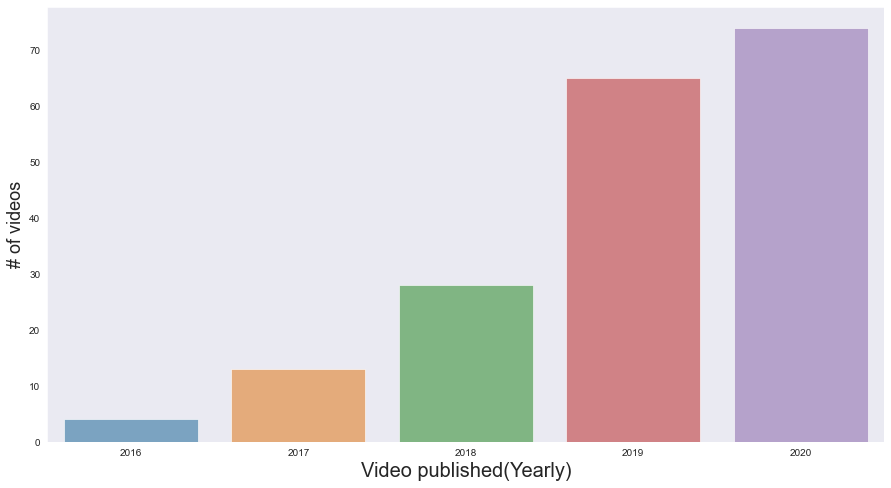

In [315]:
vid_dat = stats.video_date.dt.year.value_counts()
plt.figure(figsize=(15,8))
sns.barplot(x=vid_dat.index, y=vid_dat.values, alpha=0.6)
plt.xlabel('Video published(Yearly)', fontsize=20)
plt.ylabel('# of videos', fontsize=18);

#### It is worth noting while observing monthly trends, that the months of Sept to Nov are mainly reserved for special edition launches. However, as these products rarely make it to the hands of content creators, they possibly might not be creating videos on this till months after. 

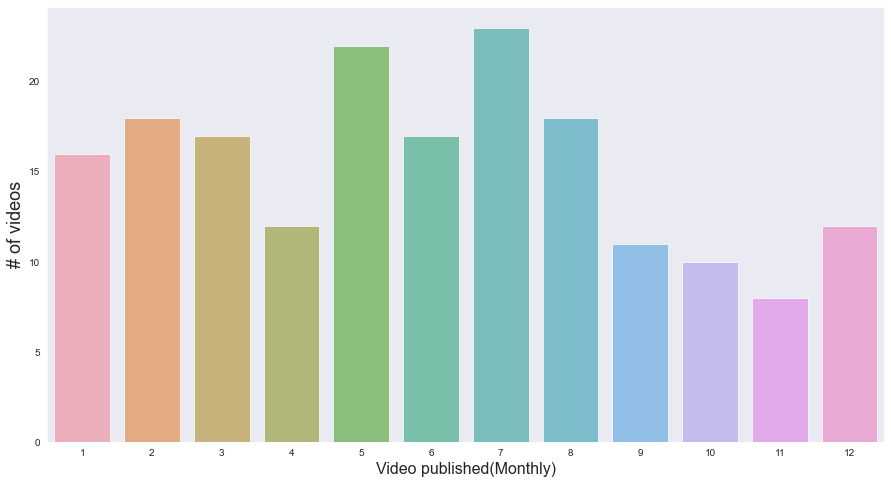

In [316]:
vid_dat = stats.video_date.dt.month.value_counts()
plt.figure(figsize=(15,8))
sns.barplot(x=vid_dat.index, y=vid_dat.values, alpha=0.7)
plt.xlabel('Video published(Monthly)', fontsize=16)
plt.ylabel('# of videos', fontsize=18);

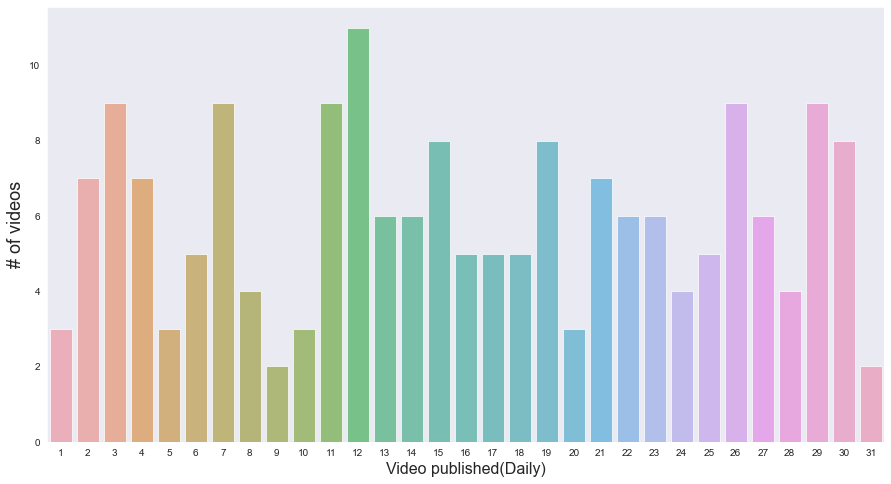

In [317]:
vid_dat = stats.video_date.dt.day.value_counts()
plt.figure(figsize=(15,8))
sns.barplot(x=vid_dat.index, y=vid_dat.values, alpha=0.7)
plt.xlabel('Video published(Daily)', fontsize=16)
plt.ylabel('# of videos', fontsize=18);

#### Surprisingly, most videos are launched either at the start or end of the work week, followed closely by the weekend

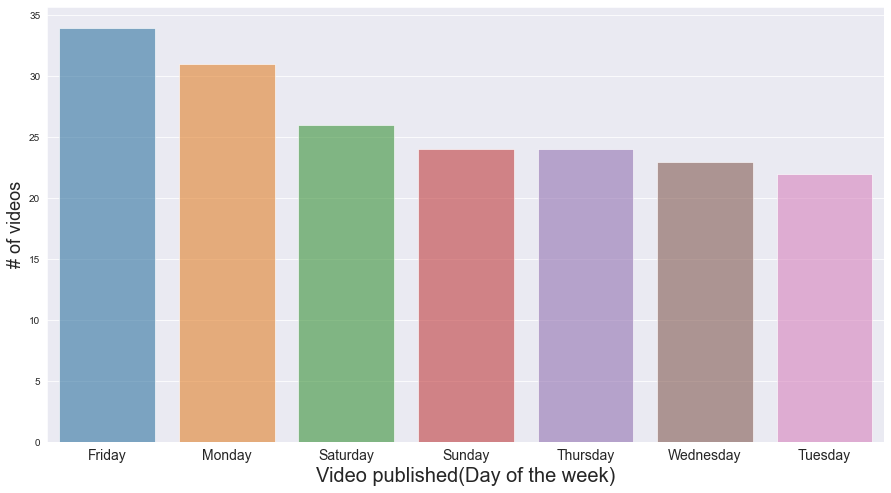

In [19]:
vid_dat_index = stats.video_date.dt.weekday.value_counts().index
vid_dat_days=[]
for i in vid_dat_index:
    vid_dat_days.append(calendar.day_name[i])


vid_dat = stats.video_date.dt.weekday.value_counts()
plt.figure(figsize=(15,8))
sns.barplot(x=vid_dat_days, y=vid_dat.values, alpha=0.6)
plt.xticks(fontsize=14)
plt.xlabel('Video published(Day of the week)', fontsize=20)
plt.ylabel('# of videos', fontsize=18);

#### Zooming into the engagement metrics acros 2016-2020, we can observe 2 main points of interest: Launch of the 2018 series and the launch of the 2020 series. The launch of the 2018 series was during Nov 2017 and there wasn't a spike in the engagement till a few months later in Mar 2018. The launch of the 2020 series however, saw a drastic increase in video views however the average number of comments and likes did not see in marked increase.

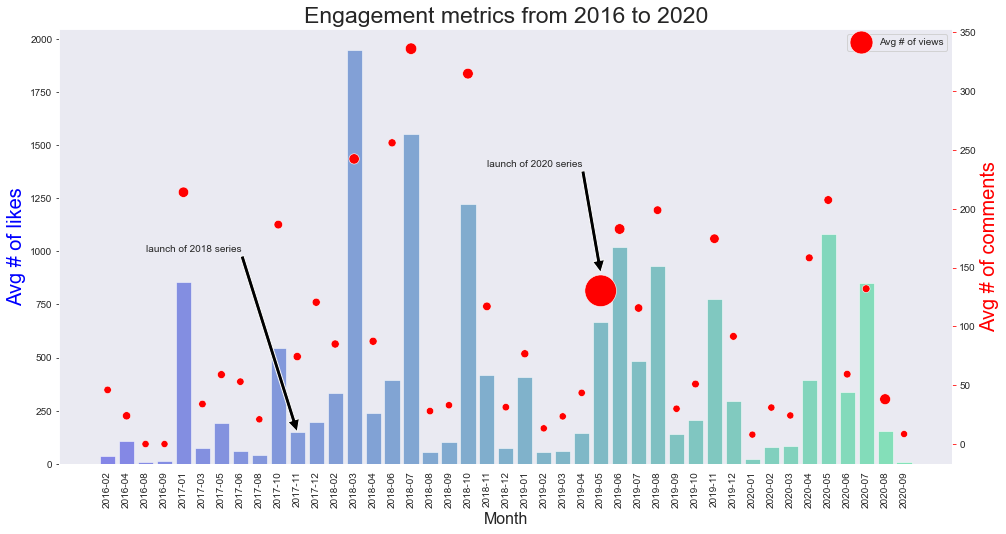

In [297]:
a = stats.groupby(stats.video_date.dt.to_period("M"))['commentCount'].mean()
b = stats.groupby(stats.video_date.dt.to_period("M"))['likeCount'].mean()
c = stats.groupby(stats.video_date.dt.to_period("M"))['viewCount'].mean()
a_index= [str(x) for x in a.index]


fig, ax1 = plt.subplots(figsize=(16,8))
color = 'tab:green'

#bar plot creation
ax1.set_title('Engagement metrics from 2016 to 2020', fontsize=23)
ax1.set_xlabel('Month', fontsize=16)
ax1.set_ylabel('Avg # of likes', fontsize=20, color='b')
sns.barplot(x=a_index, y=b.values, alpha=0.5, palette='winter', ax=ax1)
plt.xticks(rotation=90)
ax1.tick_params(axis='y')

#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'

#line plot creation
ax2.set_ylabel('Avg # of comments', fontsize=20,color='r')

sns.scatterplot(x=a_index, y=a.values, size=c.values, sizes=(50,1000), color='r', ax=ax2)
plt.legend(['Avg # of views'])
ax2.tick_params(axis='y', color='r')
ax1.annotate('launch of 2020 series', xy=(26, 900), xytext=(20, 1400),
            arrowprops=dict(facecolor='black', shrink=0.001))
ax1.annotate('launch of 2018 series', xy=(10, 150), xytext=(2, 1000),
            arrowprops=dict(facecolor='black', shrink=0.001))

#show plot
plt.show()

#### Exploring the number of videos between 2018 and 2020, we can see that there are more videos in 2020 that is bringing down the overall average in terms of likes and comments

In [21]:
stats[(stats.video_date.dt.month == 3) & (stats.video_date.dt.year == 2018) & (stats.likeCount >1500)]

,video_id,video_date,video_title,video_author,video_tags,video_duration,viewCount,likeCount,dislikeCount,commentCount
50,ZSycSfUwH6E,2018-03-17 18:04:15+00:00,Are Gaming Chairs Comfortable? — SecretLab Tit...,iPhonedo,"which gaming chair to buy,which gaming chair s...",2020-10-13 00:08:19,285148,5780,656,701


In [22]:
stats[(stats.video_date.dt.month == 5) & (stats.video_date.dt.year == 2020) & (stats.likeCount >1500)]

,video_id,video_date,video_title,video_author,video_tags,video_duration,viewCount,likeCount,dislikeCount,commentCount
1,cLBGKqcqJmg,2020-05-07 19:07:41+00:00,Secretlab Titan Review - 9 Months Later...,Stu’s Reviews,"secretlab titan review,secretlab titan 2020 re...",2020-10-13 00:16:01,207093,6347,400,902
8,nBnCOKf2V7g,2020-05-21 17:00:14+00:00,"SecretLab TITAN Gaming Chair: 2 YEARS LATER, i...",Fracno,"fracno,franco,gaming chair,secretlab titan,sec...",2020-10-13 00:12:16,89453,1912,89,362
171,J9BsxngbVEI,2020-05-08 15:17:25+00:00,Is the 2020 Secretlab Titan Gaming Chair too g...,Ben Cad,"Secretlab,secretlab titan,softweave,review,gam...",2020-10-13 00:21:00,87075,2398,65,663
172,L3_FTff8O84,2020-05-04 20:41:58+00:00,Secretlab SoftWeave VS. PU Leather - REAL LIFE...,Mike Wat,"secretlab,secretlab softweave vs pu leather,so...",2020-10-13 00:10:03,87276,1996,81,276


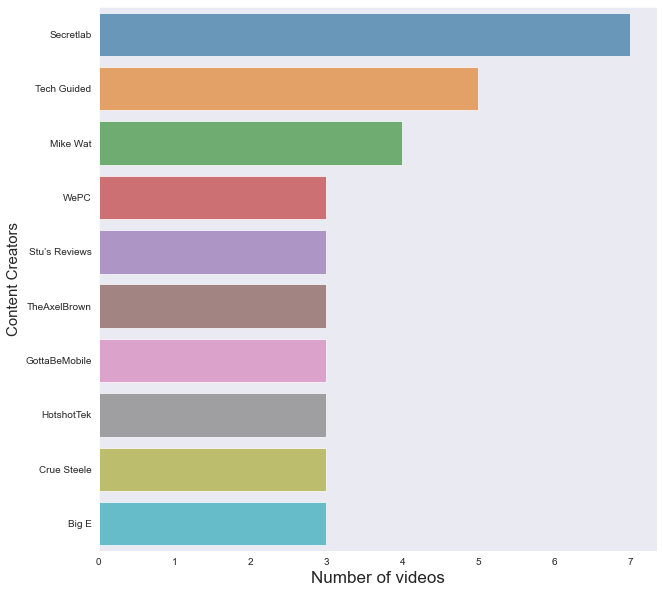

In [319]:
# Top 10 content creators 

cnt_creator = stats.video_author.value_counts()[stats.video_author.value_counts()>2]
plt.figure(figsize=(10,10))
sns.barplot(cnt_creator.values, cnt_creator.index, alpha=0.7,orient='h')
plt.xlabel('Number of videos', fontsize=17)
plt.ylabel('Content Creators', fontsize=15)
# plt.xticks(rotation=90)
plt.show();

### We shall now sort out the content creators based on their views and classify them into their respective influencer categories: 
* We would also be suggesting the top 3 creators based on their engagement metrics

In [320]:
author_stats = stats.groupby(['video_author'])['viewCount','commentCount','likeCount','dislikeCount'].sum()
author_stats.sort_values(by=['viewCount'],inplace=True,ascending=False)
author_stats.head()

,viewCount,commentCount,likeCount,dislikeCount
video_author,,,,
Secretlab,14690436,1574,8468,336
Tech Guided,590373,1297,5315,222
Mike Wat,422975,1832,8932,500
Stu’s Reviews,384995,1664,10339,554
iPhonedo,382355,920,7827,799


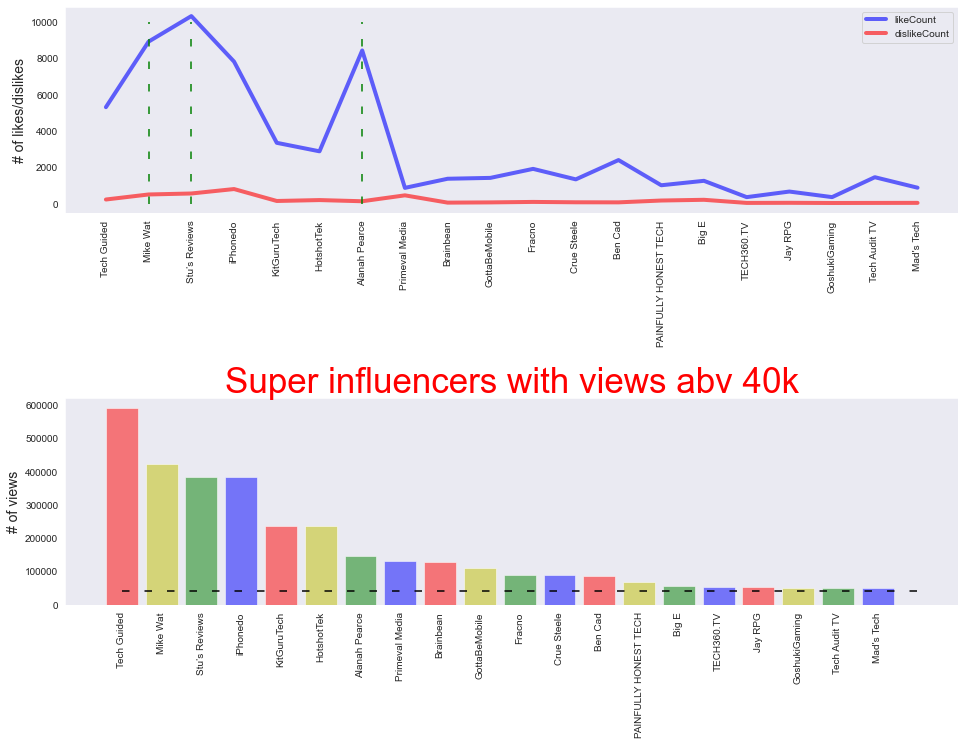

In [445]:
plt.figure(figsize=(16,11))
super_inf=author_stats[1:21] #abv 40k views
plt.subplot(211)
plt.plot(super_inf.index, 'likeCount',color='b', data=super_inf, linewidth=4,alpha=0.6)
plt.plot(super_inf.index, 'dislikeCount',color='r', data=super_inf, linewidth=4,alpha=0.6)
plt.plot([1,1],[0,1e4],color='g',linestyle=(0, (5, 10)))
plt.plot([2,2],[0,1e4],color='g',linestyle=(0, (5, 10)))
plt.plot([6,6],[0,1e4],color='g',linestyle=(0, (5, 10)))
plt.ylabel("# of likes/dislikes",fontsize=14)
plt.xticks(rotation=90)
plt.legend()
plt.subplot(212)
plt.bar(super_inf.index, 'viewCount',color='rygb', data=super_inf,alpha=0.5)
plt.plot([0,20],[4e4,4e4],color='black',linestyle=(0, (5, 10)))
plt.xticks(rotation=90)
plt.ylabel("# of views",fontsize=14)
plt.subplots_adjust(hspace=0.9)
plt.title("Super influencers with views abv 40k", fontsize=35, color='red');


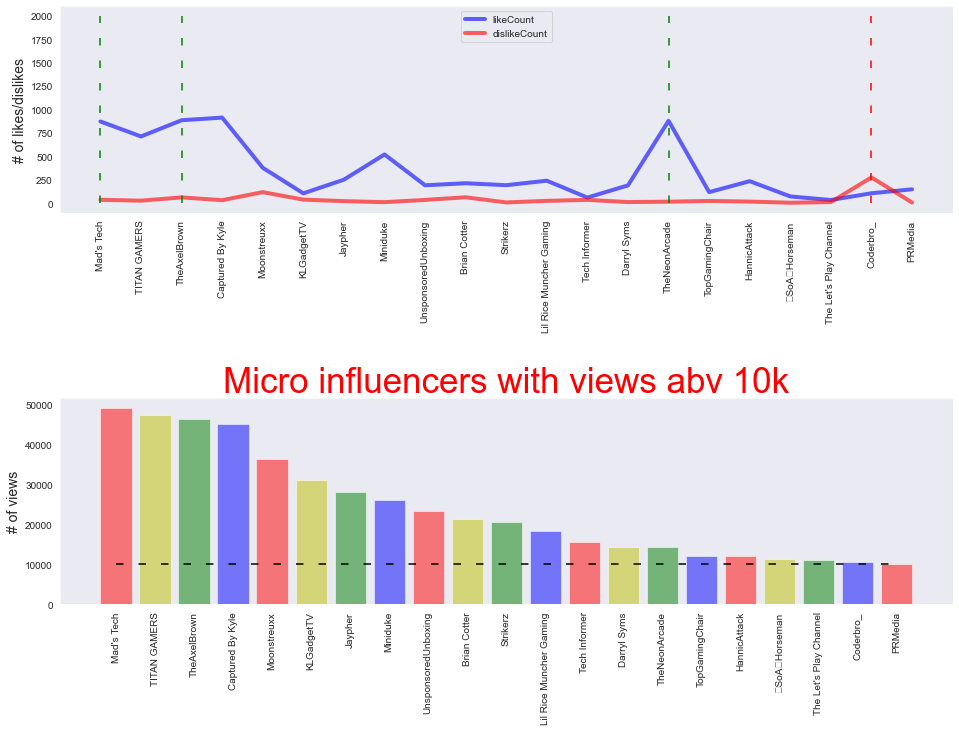

In [322]:
plt.figure(figsize=(16,11))
super_inf=author_stats[20:41]
plt.subplot(211)
plt.plot(super_inf.index, 'likeCount',color='b', data=super_inf, linewidth=4,alpha=0.6)
plt.plot(super_inf.index, 'dislikeCount',color='r', data=super_inf, linewidth=4,alpha=0.6)
plt.plot([0,0],[0,2e3],color='g',linestyle=(0, (5, 10)))
plt.plot([2,2],[0,2e3],color='g',linestyle=(0, (5, 10)))
plt.plot([14,14],[0,2e3],color='g',linestyle=(0, (5, 10)))
plt.plot([19,19],[0,2e3],color='r',linestyle=(0, (5, 10)))
plt.ylabel("# of likes/dislikes",fontsize=14)
plt.xticks(rotation=90)
plt.legend()
plt.subplot(212)
plt.bar(super_inf.index, 'viewCount',color='rygb', data=super_inf,alpha=0.5)
plt.plot([0,20],[1e4,1e4],color='black',linestyle=(0, (5, 10)))
plt.xticks(rotation=90)
plt.ylabel("# of views",fontsize=14)
plt.subplots_adjust(hspace=0.9)
plt.title("Micro influencers with views abv 10k", fontsize=35, color='red');

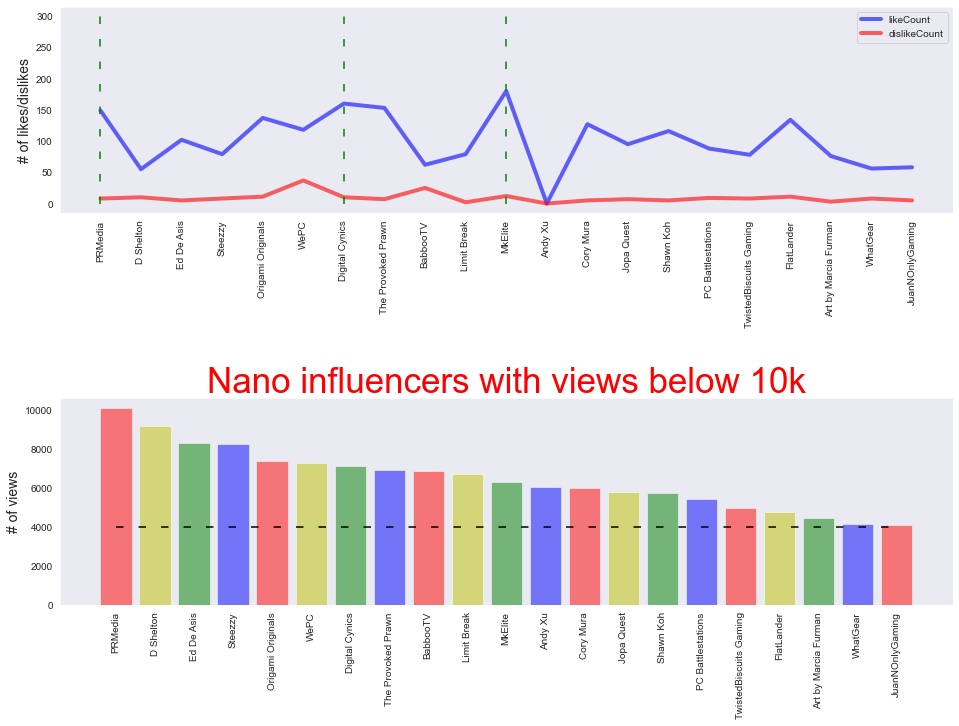

In [323]:
plt.figure(figsize=(16,11))
super_inf=author_stats[40:61] #abv 40k views
plt.subplot(211)
plt.plot(super_inf.index, 'likeCount',color='b', data=super_inf, linewidth=4,alpha=0.6)
plt.plot(super_inf.index, 'dislikeCount',color='r', data=super_inf, linewidth=4,alpha=0.6)
plt.plot([0,0],[0,3e2],color='g',linestyle=(0, (5, 10)))
plt.plot([6,6],[0,3e2],color='g',linestyle=(0, (5, 10)))
plt.plot([10,10],[0,3e2],color='g',linestyle=(0, (5, 10)))
plt.ylabel("# of likes/dislikes",fontsize=14)
plt.xticks(rotation=90)
plt.legend()
plt.subplot(212)
plt.bar(super_inf.index, 'viewCount',color='rygb', data=super_inf,alpha=0.5)
plt.plot([0,20],[4e3,4e3],color='black',linestyle=(0, (5, 10)))
plt.xticks(rotation=90)
plt.ylabel("# of views",fontsize=14)
plt.subplots_adjust(hspace=0.9)
plt.title("Nano influencers with views below 10k", fontsize=35, color='red');

### These are some content creators to watch closely as their videos seem to be highly controversial and might potentially harm the secretlab brand. Specifically, "Coderbro_" has a considerable number of views and identified as a microinfluencer

In [325]:
stats[stats.dislikeCount > stats.likeCount]

,video_id,video_date,video_title,video_author,video_tags,video_duration,viewCount,likeCount,dislikeCount,commentCount
15,jVym-RUtTMk,2020-07-04 06:22:02+00:00,Secretlab Leather | The Truth | 2 Year Review,Jon & Jas,"secretlab,gaming chair,review,leather damage,warranty replacement,the truth,secret lab,chair,tit...",2020-10-14 00:06:16,1145,8,11,6
18,FJ20JBOMOws,2019-12-06 23:34:47+00:00,"2020 Secretlab Titan Softweave Unboxing/Review (Bad Build Quality, Questionable Customer Service)",Coderbro_,"secretlab,titan,omega,secretlab titan,fortnite,call of duty,gamer,gaming,gaming chair,2020 secre...",2020-10-14 00:12:30,10746,107,276,92
44,1zvv9e-_s1Y,2016-08-15 04:23:30+00:00,Secretlab's OMEGA (PRODUCT REVIEW),TECH360.TV,"secretlab,secret lab,secretlab omega,secret lab omega,secretlab review,secret lab review,tech360...",2020-10-14 00:00:59,4963,8,14,0
102,88h8If0WLFc,2019-01-19 04:43:09+00:00,SecretLabs Titan Gaming Chair Honest Review,BrokeTechJohnny,"secretlab,titan,chair,gaming chair,dxracer,omega chair,titan chair,secret lab chair",2020-10-14 00:09:39,693,13,15,6
166,uMa70g2VLWY,2017-11-25 04:51:25+00:00,Secretlab omega and throne 2018 review: just made of better stuff,Frankie Rebollar,"secretlab,gaming chair,secretlab throne,secretlab omega",2020-10-14 00:02:11,317,0,5,0
168,XToD8uHB1BY,2017-11-25 13:45:21+00:00,Secretlab omega and throne 2018 review: just made of better stuff,benkeadam,"secretlab,gaming chair,secretlab throne,secretlab omega",2020-10-14 00:02:11,169,1,2,0


#### There are 19 content creators who have not tagged their videos. This would affect their SEO rankings and potentially restrict the reach of their videos.

In [328]:
stats.shape[0] - stats.video_tags.nunique()

19

#### To assist these content creators, we have grouped the top keyword tags and offer a randomised set of 5 tags they could potentially use in the videos

In [31]:
raw_tags = []
try:
    for d in stats.video_tags.unique():
        for word in d.split(","):
            raw_tags.append(word)
except:
    pass


vid_tags_dict = {}
for word in raw_tags:
    if word in vid_tags_dict.keys():
        vid_tags_dict[word] += 1
    else:
        vid_tags_dict[word] = 1

vt = pd.DataFrame.from_dict(vid_tags_dict, orient='index', columns=['values'])
vt.sort_values(['values'],ascending=False,inplace=True)
suggested_tags = vt.head(40).index
suggested_tags

Index(['gaming chair', 'secret lab chair', 'best gaming chair', 'secretlab',
       'secret lab gaming chair', 'secretlab titan review', 'secret lab',
       'gaming chair review', 'secret lab chair review', 'secret lab titan',
       'secretlab chair', 'secretlab review', 'secretlab titan',
       'secret lab review', 'best gaming chairs', 'titan', 'secretlab omega',
       'secret lab titan chair', 'review', 'secretlab titan chair',
       'secret labs titan', 'titan chair', 'secret lab titan review',
       'secret lab titan 2020', 'omega gaming chair', 'gaming',
       'best pc gaming chair', 'secret lab omega', 'secretlab omega 2020',
       'chair', 'gamer', 'secretlabs titan', 'omega',
       'secret lab honest review', 'secretlab titan 2020 review', 'Gaming',
       'secretlab review titan', '2020', 'secret labs', 'titan 2020 review'],
      dtype='object')

In [329]:
qn = input("Would you like some suggested video tags? y or n\n")
if qn == "y" :
    print("\nHere are 5 suggestions for you:\n")
    temp = np.random.choice(suggested_tags, 5, replace=False)
    for wd in temp:
        print(wd)
if qn == "n" :
    print("Have a nice day")

Would you like some suggested video tags? y or n
y

Here are 5 suggestions for you:

secret lab honest review
secret lab omega
best gaming chair
secret lab titan chair
gaming


# Comments from videos

### Let's now dive at a granular level into the video comments and replies. 

Specifically we would like to explore the following relationships:
1. The response time between comments and each of their replies
2. Total number of likes the comment has received (already obtained through the API)
3. The total number of replies and reply likes that comment has received
4. The comments and replies against the hour posted during the day
5. The comments and replies against the day of the week posted
6. The # of words in the comment vs the likes/replies it received


#### There are duplicate comments due to row created for each reply to the comment, which will be cleaned up later

In [330]:
comments = pd.read_csv('videocomments.csv')

In [331]:
comments.info()
comments.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13156 entries, 0 to 13155
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   videoid         13156 non-null  object 
 1   comment         13156 non-null  object 
 2   comment_likes   13156 non-null  int64  
 3   comment_author  13156 non-null  object 
 4   comment_date    13156 non-null  object 
 5   comment_reply   7369 non-null   object 
 6   reply_author    7369 non-null   object 
 7   reply_likes     7369 non-null   float64
 8   reply_date      7369 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 925.2+ KB


,videoid,comment,comment_likes,comment_author,comment_date,comment_reply,reply_author,reply_likes,reply_date
0,31glAeRYkD4,⚠️ *MY TITAN AFTER 9 MONTHS* ⚠️ - https://youtu.be/cLBGKqcqJmg,14,Stu’s Reviews,2020-04-08 14:39:22+00:00,NaN,NaN,NaN,NaN
1,31glAeRYkD4,bro how did you carry the 400 pound chair into your house,0,Cris Burke,2020-09-26 03:56:51+00:00,💪,Stu’s Reviews,1.0,2020-09-26 10:07:55+00:00
2,31glAeRYkD4,"""Comfort is a 5. I no longer have any back problems and it's done me the world of good. It allow...",0,Shibby120,2020-09-20 18:53:00+00:00,NaN,NaN,NaN,NaN
3,31glAeRYkD4,I literly got a secret lab advertising during this vidro,0,Pep Stufkens,2020-09-17 07:46:23+00:00,NaN,NaN,NaN,NaN
4,31glAeRYkD4,"comfy is based on the individual , in my opinion this chair is very comfortable",0,Dr Voodoo,2020-09-16 23:38:30+00:00,NaN,NaN,NaN,NaN
5,31glAeRYkD4,The editing meets a level of camp missing from tech and I appreciate.,0,Joshua Swartzentruber,2020-09-03 15:04:32+00:00,NaN,NaN,NaN,NaN
6,31glAeRYkD4,"also you need to lub every part that comes with gaming chair, they are all made in china by chea...",0,Klemen Kovačič,2020-09-01 14:22:01+00:00,NaN,NaN,NaN,NaN
7,31glAeRYkD4,"at least your chair didnt come in a box that says ""MADE IN CHINA"" haha",0,Klemen Kovačič,2020-09-01 14:13:58+00:00,Everything is made in China. Including 18% of the population of earth 👀,Stu’s Reviews,0.0,2020-09-01 14:57:10+00:00
8,31glAeRYkD4,2:33 the most annoying part of getting chair together is that part phahaha\ni had to spent quite...,0,Klemen Kovačič,2020-09-01 14:12:35+00:00,NaN,NaN,NaN,NaN
9,31glAeRYkD4,"I got my titan xl yesterday and woke up with a sore ass of how firm the seat is, disappointed bu...",0,Efrain Sanchez,2020-08-30 08:27:44+00:00,NaN,NaN,NaN,NaN


In [348]:
# change dates to datetime format
comments['comment_time'] = pd.to_datetime(comments.comment_date, errors='coerce')
comments['reply_time'] = pd.to_datetime(comments.reply_date, errors='coerce')
comments['comment_date'] = pd.to_datetime(comments.comment_date, errors='coerce')
comments['reply_date'] = pd.to_datetime(comments.reply_date, errors='coerce')

In [333]:
# filling nan values of reply likes for further computation
comments.reply_likes = comments.reply_likes.fillna(0)
comments.reply_likes = comments.reply_likes.astype(int)

In [334]:
# create a column counting the number of english words in each comment
comments['com_numofwords'] = comments.comment.apply(lambda x: len(re.findall(r"[\w']+", x.lower())))

#### Let's explore the relationship between the response time of replies to their main comments

In [335]:
def timediff(x,y):
    asd=x-y
    if asd.days != 0:
        return str(asd.days)+" days"
    else:
        return str(round(asd.seconds/60))+" mins"
    
comments['responsetime'] = comments.apply(lambda x: timediff(x.reply_date, x.comment_date), axis=1)

In [336]:
days_raw = comments.responsetime[~comments.responsetime.str.contains("nan") &  comments.responsetime.str.contains("days")].unique()
days_num = [int(x.split()[0]) for x in days_raw]
max(days_num)

1119

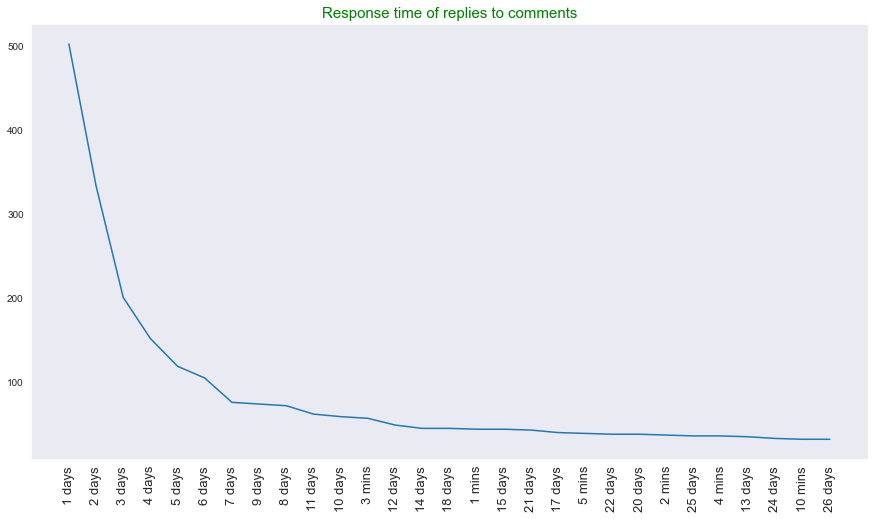

In [337]:
plt.figure(figsize=(15,8))
plt.plot(comments.responsetime.value_counts()[1:30])
plt.xticks(rotation=90,fontsize=13)
plt.title("Response time of replies to comments",fontsize=15,color='g');

#### Observations:
* Most of the replies came in after a day of the comment
* Most of the replies came in within the week of the comment
* The most frequent response time of replies within the day of the comment was 3mins
* The latest reply to a comment came in after 1119 days ~ 3 years!

In [74]:
comments.info()
comments.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13156 entries, 0 to 13155
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   videoid          13156 non-null  object             
 1   comment          13156 non-null  object             
 2   comment_likes    13156 non-null  int64              
 3   comment_author   13156 non-null  object             
 4   comment_date     13156 non-null  datetime64[ns, UTC]
 5   comment_reply    7369 non-null   object             
 6   reply_author     7369 non-null   object             
 7   reply_likes      13156 non-null  int64              
 8   reply_date       7369 non-null   datetime64[ns, UTC]
 9   comment_time     13156 non-null  datetime64[ns, UTC]
 10  reply_time       7369 non-null   datetime64[ns, UTC]
 11  com_numofwords   13156 non-null  int64              
 12  responsetime     13156 non-null  object             
 13  tot_replies     

/Users/prakky/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count,mean,std,min,25%,50%,75%,max
comment_likes,13156.0,7.607251,48.386839,0.0,0.0,0.0,2.0,1239.0
reply_likes,13156.0,0.285725,0.984214,0.0,0.0,0.0,0.0,33.0
com_numofwords,13156.0,30.295911,43.245741,0.0,9.0,18.0,35.0,721.0
tot_replies,13156.0,1.650426,1.960525,0.0,0.0,1.0,3.0,12.0
tot_reply_likes,13156.0,0.909699,2.382929,0.0,0.0,0.0,1.0,41.0


##### We can observe that the longest comment is made up of 721 words and the average comment length is about 30 words. 
The most number of likes received for a comment was a staggering **1239 likes**. Let's zoom into the exact comment that made it so popular.

In [75]:
comments[comments.comment_likes == 1239]

/Users/prakky/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,videoid,comment,comment_likes,comment_author,comment_date,comment_reply,reply_author,reply_likes,reply_date,comment_time,reply_time,com_numofwords,responsetime,tot_replies,tot_reply_likes
9979,Fkey2ZvX6lU,one of the best ads i've ever seen,1239,Julian Crist,2019-06-02 06:57:47+00:00,That music tho,Anže Kranjc,0,2020-08-20 09:22:26+00:00,2019-06-02 06:57:47+00:00,2020-08-20 09:22:26+00:00,8,445 days,5,3
9980,Fkey2ZvX6lU,one of the best ads i've ever seen,1239,Julian Crist,2019-06-02 06:57:47+00:00,Why a review? This ad has all the reviews😅,Cirjan David,0,2020-07-15 07:08:38+00:00,2019-06-02 06:57:47+00:00,2020-07-15 07:08:38+00:00,8,409 days,5,3
9981,Fkey2ZvX6lU,one of the best ads i've ever seen,1239,Julian Crist,2019-06-02 06:57:47+00:00,JUST CIZ OF THE SONG,Steve Thea,1,2020-06-08 07:45:20+00:00,2019-06-02 06:57:47+00:00,2020-06-08 07:45:20+00:00,8,372 days,5,3
9982,Fkey2ZvX6lU,one of the best ads i've ever seen,1239,Julian Crist,2019-06-02 06:57:47+00:00,True ever,Sticks Forever,1,2020-06-05 19:40:19+00:00,2019-06-02 06:57:47+00:00,2020-06-05 19:40:19+00:00,8,369 days,5,3
9983,Fkey2ZvX6lU,one of the best ads i've ever seen,1239,Julian Crist,2019-06-02 06:57:47+00:00,Julian Crist I agree,Everything Random,1,2020-05-27 17:57:00+00:00,2019-06-02 06:57:47+00:00,2020-05-27 17:57:00+00:00,8,360 days,5,3


#### We'll now concatatenate the sum of the reply count and reply likes into a new df: "unique_comm" to visualise the comment relationships over time

In [338]:
def add_mkt_return(grp):
    grp['tot_replies'] = grp['reply_author'].count()
    grp['tot_reply_likes'] = grp['reply_likes'].sum()
    return grp

comments = comments.groupby('comment').apply(add_mkt_return)

In [339]:
uniq_comm = comments.drop_duplicates(subset=['comment'])
uniq_comm.drop(columns=['comment_reply','reply_author','reply_likes','reply_date','comment_time','reply_time','responsetime'],inplace=True)

In [340]:
uniq_comm.info()
uniq_comm.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9480 entries, 0 to 13155
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   videoid          9480 non-null   object             
 1   comment          9480 non-null   object             
 2   comment_likes    9480 non-null   int64              
 3   comment_author   9480 non-null   object             
 4   comment_date     9480 non-null   datetime64[ns, UTC]
 5   com_numofwords   9480 non-null   int64              
 6   tot_replies      9480 non-null   int64              
 7   tot_reply_likes  9480 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(4), object(3)
memory usage: 666.6+ KB


,videoid,comment,comment_likes,comment_author,comment_date,com_numofwords,tot_replies,tot_reply_likes
0,31glAeRYkD4,⚠️ *MY TITAN AFTER 9 MONTHS* ⚠️ - https://youtu.be/cLBGKqcqJmg,14,Stu’s Reviews,2020-04-08 14:39:22+00:00,9,0,0
1,31glAeRYkD4,bro how did you carry the 400 pound chair into your house,0,Cris Burke,2020-09-26 03:56:51+00:00,12,1,1
2,31glAeRYkD4,"""Comfort is a 5. I no longer have any back problems and it's done me the world of good. It allow...",0,Shibby120,2020-09-20 18:53:00+00:00,29,0,0
3,31glAeRYkD4,I literly got a secret lab advertising during this vidro,0,Pep Stufkens,2020-09-17 07:46:23+00:00,10,0,0
4,31glAeRYkD4,"comfy is based on the individual , in my opinion this chair is very comfortable",0,Dr Voodoo,2020-09-16 23:38:30+00:00,14,0,0
5,31glAeRYkD4,The editing meets a level of camp missing from tech and I appreciate.,0,Joshua Swartzentruber,2020-09-03 15:04:32+00:00,13,0,0
6,31glAeRYkD4,"also you need to lub every part that comes with gaming chair, they are all made in china by chea...",0,Klemen Kovačič,2020-09-01 14:22:01+00:00,83,0,0
7,31glAeRYkD4,"at least your chair didnt come in a box that says ""MADE IN CHINA"" haha",0,Klemen Kovačič,2020-09-01 14:13:58+00:00,15,1,0
8,31glAeRYkD4,2:33 the most annoying part of getting chair together is that part phahaha\ni had to spent quite...,0,Klemen Kovačič,2020-09-01 14:12:35+00:00,26,0,0
9,31glAeRYkD4,"I got my titan xl yesterday and woke up with a sore ass of how firm the seat is, disappointed bu...",0,Efrain Sanchez,2020-08-30 08:27:44+00:00,26,0,0


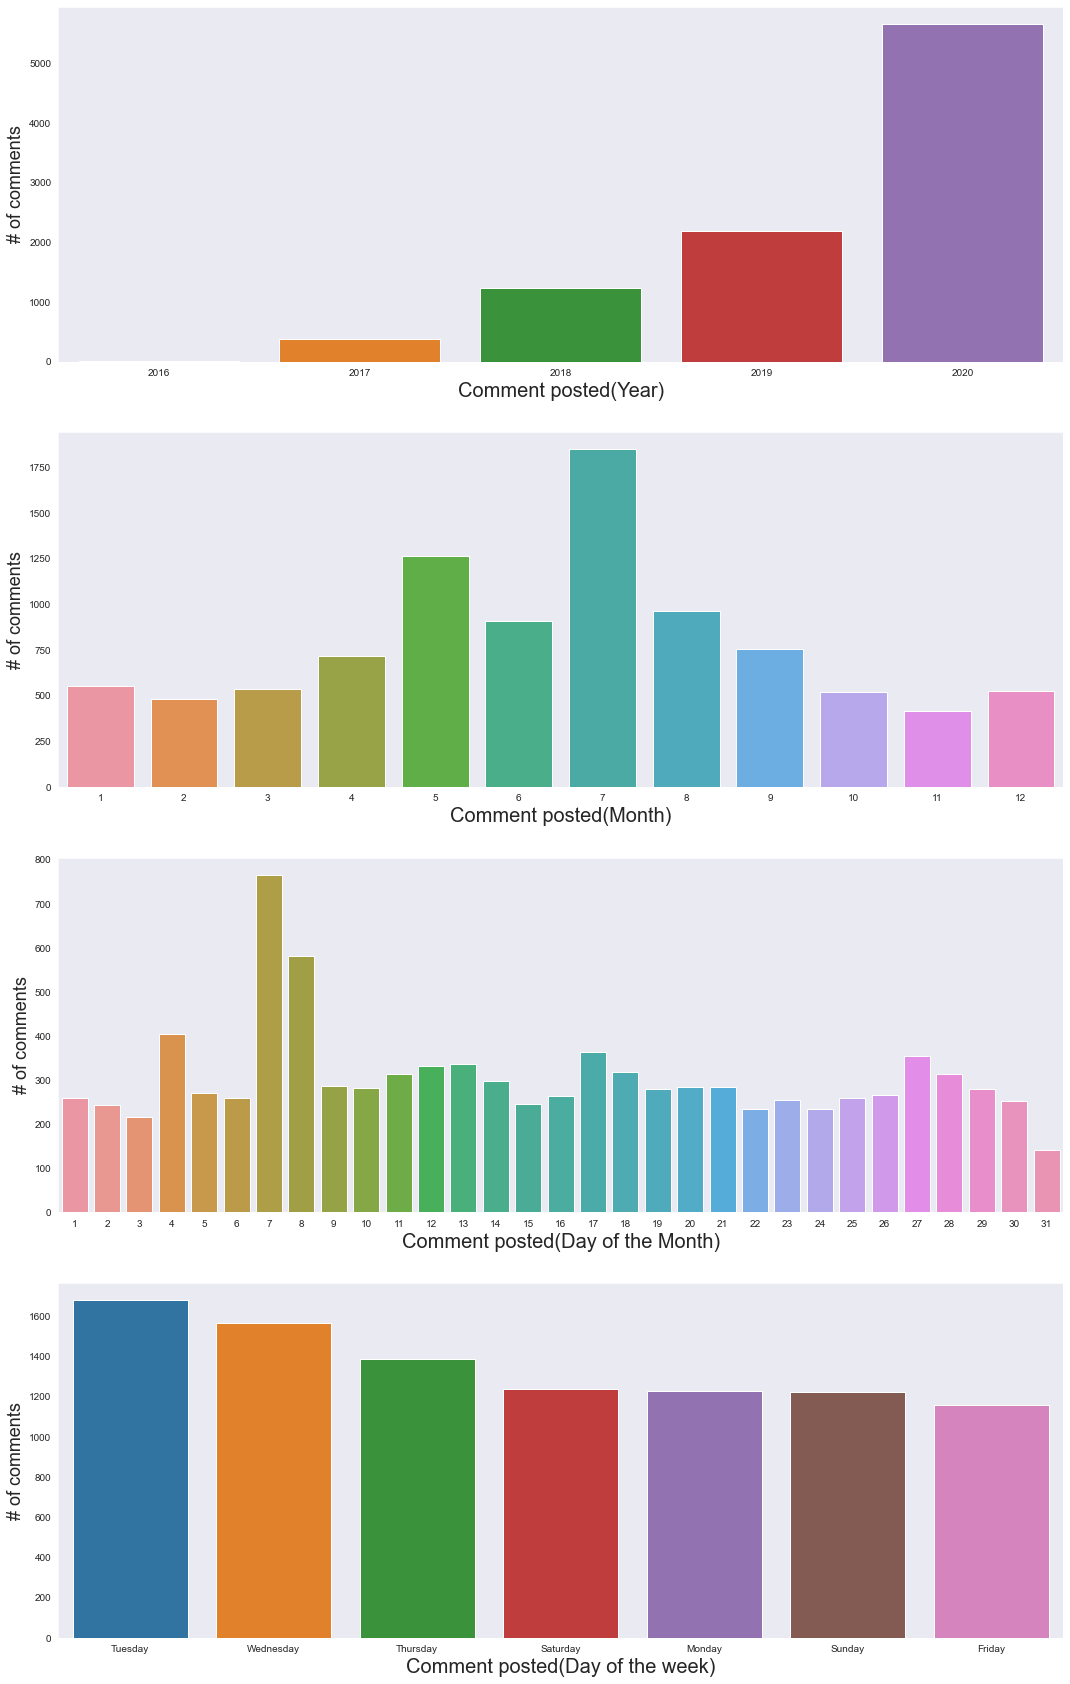

In [354]:
vid_dat_index = uniq_comm.comment_date.dt.weekday.value_counts().index
vid_dat_days=[]
for i in vid_dat_index:
    vid_dat_days.append(calendar.day_name[i])

fig,ax = plt.subplots(4,1,figsize = (18, 30))

sns.countplot(x=uniq_comm['comment_date'].dt.year, ax=ax[0])
ax[0].set_xlabel('Comment posted(Year)', fontsize=20)
ax[0].set_ylabel('# of comments', fontsize=18);
sns.countplot(x=uniq_comm['comment_date'].dt.month, ax=ax[1])
ax[1].set_xlabel('Comment posted(Month)', fontsize=20)
ax[1].set_ylabel('# of comments', fontsize=18);
sns.countplot(x=uniq_comm['comment_date'].dt.day, ax=ax[2])
ax[2].set_xlabel('Comment posted(Day of the Month)', fontsize=20)
ax[2].set_ylabel('# of comments', fontsize=18);
sns.barplot(x=vid_dat_days, y=uniq_comm.comment_date.dt.weekday.value_counts(), ax=ax[3])
ax[3].set_xlabel('Comment posted(Day of the week)', fontsize=20)
ax[3].set_ylabel('# of comments', fontsize=18);

#### Interestingly, even though most videos come out on Friday and Monday , most of the comments peak on Tuesday and Wednesday

#### The comments and replies by hour seem to follow the same trend generally, with a clear outlier in the comments space with a majority coming out at 7pm

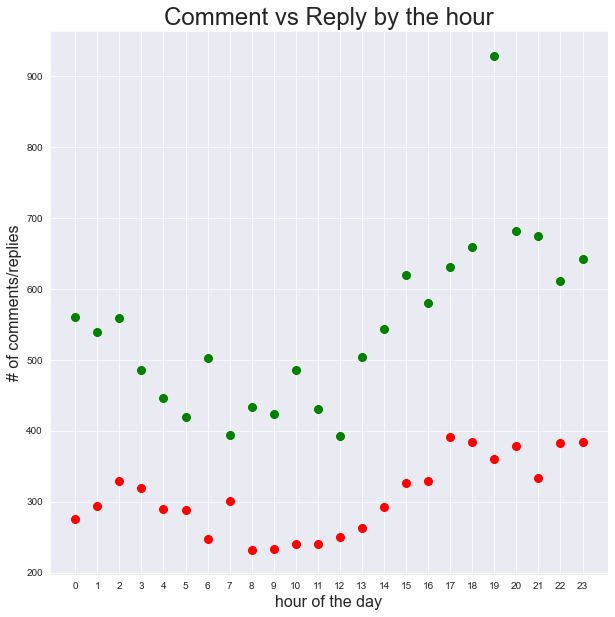

In [41]:
# do a plot for comment time and reply time
fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.scatterplot(x = comments.comment_date.dt.hour.value_counts().index, y = comments.comment_date.dt.hour.value_counts().values, 
             s=100, color = 'green' ,ax = ax)

sns.scatterplot(x = comments.reply_date.dt.hour.value_counts().index.astype(int), y = comments.reply_date.dt.hour.value_counts().values,
             s=100, ax = ax, color = 'red')

plt.xlabel("hour of the day", fontsize=16)
plt.ylabel("# of comments/replies", fontsize=16)
plt.xticks(range(0,24))
plt.title('Comment vs Reply by the hour', fontsize=24);

In [342]:
#of words vs likes , replies
words_vs = uniq_comm[['tot_replies','tot_reply_likes','comment_likes']].groupby(uniq_comm.com_numofwords).sum()
words_vs.reset_index(inplace=True)
words_vs

,com_numofwords,tot_replies,tot_reply_likes,comment_likes
0,0,2,0,8
1,1,40,18,69
2,2,62,17,156
3,3,74,17,277
4,4,151,48,257
...,...,...,...,...
249,509,0,0,0
250,559,2,0,1
251,608,0,0,6
252,633,4,2,12


In [356]:
#creating the plot variables

bins = [0,1,10,15,20,30,50,100,150,200,300,500,730]
labels= ["<2 words", "2-10 words", "11-15 words", "16-20 words", "21-30 words", "31-50 words", "51-100 words",
         "101-150 words", "151-200 words","201-300 words", "301-500 words", ">500 words"]
cl = words_vs.groupby(pd.cut(words_vs['com_numofwords'], bins=bins, labels=labels))['comment_likes'].sum()
tr = words_vs.groupby(pd.cut(words_vs['com_numofwords'], bins=bins, labels=labels))['tot_replies'].sum()
trl = words_vs.groupby(pd.cut(words_vs['com_numofwords'], bins=bins, labels=labels))['tot_reply_likes'].sum()
trl

com_numofwords
<2 words          18
2-10 words       816
11-15 words      558
16-20 words      450
21-30 words      662
31-50 words      633
51-100 words     431
101-150 words     98
151-200 words     16
201-300 words     60
301-500 words     11
>500 words         6
Name: tot_reply_likes, dtype: int64

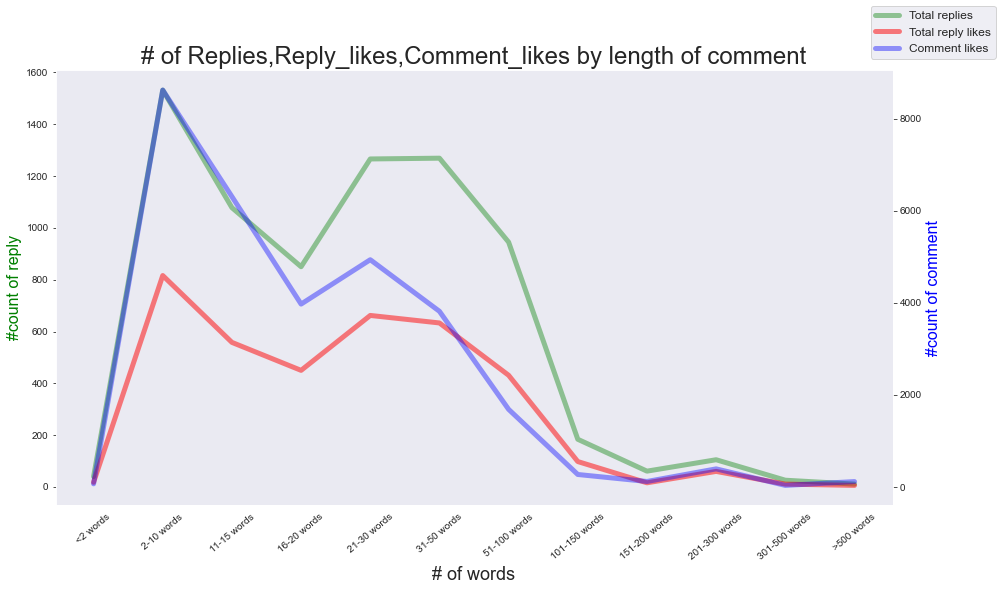

In [384]:
fig, ax = plt.subplots(1,1, figsize=(15,8))

ax1=sns.lineplot(x = tr.index, y = tr.values, color = 'green', label="Total replies", linewidth=5, alpha=0.4)
ax1.get_legend().remove()
ax2=sns.lineplot(x = trl.index, y = trl.values, color = 'red', label="Total reply likes", linewidth=5, alpha=0.5)
ax2.get_legend().remove()
plt.xlabel("# of words", fontsize=18)
plt.ylabel("#count of reply", fontsize=16, color='g')
plt.xticks(rotation=40)
ax3 = ax1.twinx()

ax3=sns.lineplot(x = cl.index, y = cl.values, color = 'blue', label ="Comment likes", linewidth=5, alpha=0.4)
ax3.get_legend().remove()

plt.ylabel("#count of comment", fontsize=16, color='b')
plt.title('# of Replies,Reply_likes,Comment_likes by length of comment', fontsize=24)

# Combine handles & labels from 2 subplots
handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(),ax3.get_legend_handles_labels())]
        
# additional manual adjustment to the figure    
fig.legend(handles, labels, loc='upper right', prop={'size': 12});

# More Brand insights using Spacy and Word2Vec

* We will be using Spacy's Named Entity Recognition to derive some insights based on the entity tags
* We will be using W2Vec to derive a bag of words and plot a TSNE diagram to reduce the dimensionality and visualise the word vectors

In [54]:
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Word2Vec, Doc2Vec
from pprint import pprint

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import utils


import spacy
nlp = spacy.load("en_core_web_sm")

In [402]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)# remove single quotes
        sent = sent.replace("http","")
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list

data = uniq_comm.comment
data_words = list(sent_to_words(data))
print(len(data_words),len(data))

/Users/prakky/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<ipython-input-402-902ac789f94c>:3: DeprecationWarning: invalid escape sequence \s
  sent = re.sub('\s+', ' ', sent)  # remove newline chars


6247 6247


In [403]:
start_time = time.time()

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Strip words and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc))] for doc in texts]
#     texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

data_ready = process_words(data_words)
print(len(data_ready))
print ("\ntotal time taken:",(time.time() - start_time)/60, "min")

/Users/prakky/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


6247

total time taken: 0.29810505310694374 min


In [404]:
from collections import Counter

com_wds = [x for sublist in data_ready for x in sublist]

count = Counter(com_wds)
print(count.most_common()[:100])

[('chair', 5070), ('be', 1646), ('just', 1429), ('review', 1371), ('so', 1224), ('get', 1102), ('can', 1097), ('buy', 1072), ('good', 1012), ('back', 975), ('video', 966), ('look', 913), ('will', 884), ('would', 856), ('go', 826), ('thank', 822), ('sit', 805), ('have', 802), ('omega', 771), ('titan', 763), ('make', 738), ('how', 710), ('use', 709), ('well', 692), ('more', 667), ('think', 648), ('really', 637), ('now', 634), ('great', 628), ('leather', 618), ('game', 605), ('see', 587), ('year', 579), ('seat', 575), ('say', 540), ('when', 533), ('want', 523), ('very', 510), ('time', 482), ('love', 480), ('too', 476), ('also', 473), ('order', 472), ('support', 467), ('much', 460), ('only', 452), ('feel', 437), ('know', 430), ('comfortable', 405), ('work', 380), ('need', 375), ('still', 373), ('month', 368), ('one', 363), ('secret', 363), ('day', 359), ('people', 359), ('should', 355), ('long', 352), ('same', 347), ('come', 346), ('find', 341), ('lab', 341), ('secretlab', 337), ('even', 3

/Users/prakky/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [406]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

/Users/prakky/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [407]:
len(corpus), len(id2word)

/Users/prakky/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(6247, 6383)

## SPACY Named Entity Recognition insights

In [ ]:
# A list of all the entities that SPACY provides but we will be only examining a few crucial ones

# TYPE	DESCRIPTION
# PERSON	People, including fictional.
# NORP	Nationalities or religious or political groups.
# FAC	Buildings, airports, highways, bridges, etc.
# ORG	Companies, agencies, institutions, etc.
# GPE	Countries, cities, states.
# LOC	Non-GPE locations, mountain ranges, bodies of water.
# PRODUCT	Objects, vehicles, foods, etc. (Not services.)
# EVENT	Named hurricanes, battles, wars, sports events, etc.
# WORK_OF_ART	Titles of books, songs, etc.
# LAW	Named documents made into laws.
# LANGUAGE	Any named language.
# DATE	Absolute or relative dates or periods.
# TIME	Times smaller than a day.
# PERCENT	Percentage, including ”%“.
# MONEY	Monetary values, including unit.
# QUANTITY	Measurements, as of weight or distance.
# ORDINAL	“first”, “second”, etc.
# CARDINAL	Numerals that do not fall under another type.

In [338]:
mainframe = pd.DataFrame(columns=['text', 'type'])

for line in data:
    doc = nlp(line)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    old_df = pd.DataFrame(entities, columns=['text', 'type'])
    mainframe = mainframe.append(old_df)
    del old_df, entities

In [331]:
mainframe.type.value_counts()

DATE           2118
CARDINAL       1682
PERSON         1542
ORG            1309
GPE            1033
MONEY           468
QUANTITY        445
TIME            436
ORDINAL         291
LOC             272
PRODUCT         165
NORP            149
FAC             119
WORK_OF_ART      73
PERCENT          68
EVENT            19
LAW              16
LANGUAGE         15
Name: type, dtype: int64

In [332]:
mainframe[mainframe.type == 'DATE']['text'].value_counts()[:10]

2020           125
today           89
yesterday       54
2018            37
a year          32
a few weeks     26
all day         25
2 years         24
years           23
tomorrow        22
Name: text, dtype: int64

In [339]:
mainframe[mainframe.type == 'ORG']['text'].value_counts()[:10]

Aeron         54
XL            51
SecretLab     36
Secret Lab    34
DXRacer       24
PU Leather    21
Amazon        21
Chair         20
kinda         18
IKEA          16
Name: text, dtype: int64

In [341]:
mainframe[mainframe.type == 'PERSON']['text'].value_counts()[:10]

Omega                  361
Herman Miller           95
Secretlab               64
Mike                    30
herman miller           29
Secret Labs             28
Herman Miller Aeron     21
Steelcase               15
Titan XL                14
Ben                     13
Name: text, dtype: int64

In [340]:
mainframe[mainframe.type == 'TIME']['text'].value_counts()[:10]

hours                40
a few hours          14
long hours           10
30 minutes            7
2 hours               7
this morning          6
last night            6
8 hours               6
more than an hour     5
12 hours              5
Name: text, dtype: int64

In [342]:
mainframe[mainframe.type == 'GPE']['text'].value_counts()[:10]

Titan         544
Alanah         48
PU             36
Singapore      21
Secretlabs     20
US             19
UK             17
Malaysia       15
Australia      12
titan          11
Name: text, dtype: int64

In [343]:
mainframe[mainframe.type == 'QUANTITY']['text'].value_counts()[:10]

180cm         10
80kg           9
170cm          8
a ton          8
175cm          8
5 foot         6
6 feet         5
176cm          5
180 pounds     5
95kg           4
Name: text, dtype: int64

## Word2Vec insights

In [496]:
w2v_model = Word2Vec(min_count=2,
                     window=5,
                     hs=1,
                     sg=1,
                     sample=1e-5,
                     seed=42,
                     negative=5,
                    size=50,
)

In [497]:
t = time.time()

w2v_model.build_vocab(data_ready)

print('Time to build vocab: {} sec'.format(round((time.time() - t), 2)))

Time to build vocab: 0.69 sec


In [498]:
t = time.time()

w2v_model.train(data_ready, total_examples=w2v_model.corpus_count, epochs=1000, start_alpha=0.1,end_alpha=0.0001)

print(f'Time to train the model: {round((time.time() - t)/60, 2)} min')

Time to train the model: 0.85 min


In [499]:
w2v_model.wv.most_similar(positive=["omega"])

[('titan', 0.7777377367019653),
 ('size', 0.7686271667480469),
 ('big', 0.7619995474815369),
 ('help', 0.7594087719917297),
 ('tall', 0.7428501844406128),
 ('height', 0.7186198830604553),
 ('lbs', 0.7179155349731445),
 ('wide', 0.701420783996582),
 ('may', 0.6765795946121216),
 ('leg', 0.6663681864738464)]

In [500]:
w2v_model.wv.most_similar(positive=["titan"])

[('omega', 0.7777377367019653),
 ('think', 0.7555432319641113),
 ('help', 0.7218170762062073),
 ('support', 0.7108168601989746),
 ('actually', 0.7074431777000427),
 ('big', 0.701764702796936),
 ('buy', 0.6932166814804077),
 ('see', 0.6896942257881165),
 ('may', 0.6888666152954102),
 ('great', 0.6808136701583862)]

In [507]:
w2v_model.predict_output_word(['my', 'next', 'chair', 'will', 'be'], topn=10)

[('worn', 0.01168655),
 ('scream', 0.007911612),
 ('backup', 0.007831355),
 ('symptom', 0.0064958106),
 ('wave', 0.006039662),
 ('circle', 0.005978039),
 ('program', 0.0058969483),
 ('news', 0.005699329),
 ('triangle', 0.0056111636),
 ('dealer', 0.005006789)]

In [502]:
w2v_model.wv.relative_cosine_similarity('buy','omega')

0.06996956645724846

In [503]:
w2v_model.wv.relative_cosine_similarity('buy','titan')

0.09292699185735538

In [504]:
w2v_model.wv.most_similar(positive=["fabric", "leather"], negative=["cool"], topn=5)

[('softweave', 0.6305164694786072),
 ('hot', 0.6189433336257935),
 ('flake', 0.617984414100647),
 ('sweat', 0.6054732203483582),
 ('material', 0.6045715808868408)]

In [482]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 50), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 800 to 20 dimensions with PCA
    reduc = PCA(n_components=11).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=42, perplexity=10, learning_rate=150).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title(f't-SNE visualization for {word.title()}')

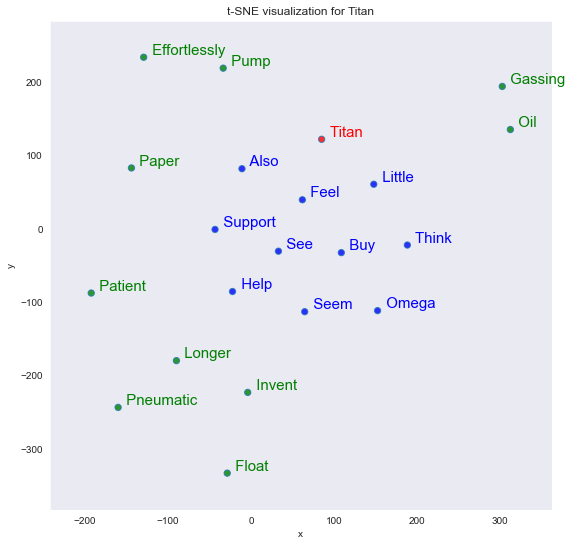

In [483]:
#we're looking for a clear distinction between similiar and dissimliar words

tsnescatterplot(w2v_model, "titan", [t[0] for t in w2v_model.wv.most_similar(negative=["titan"], topn=10)])

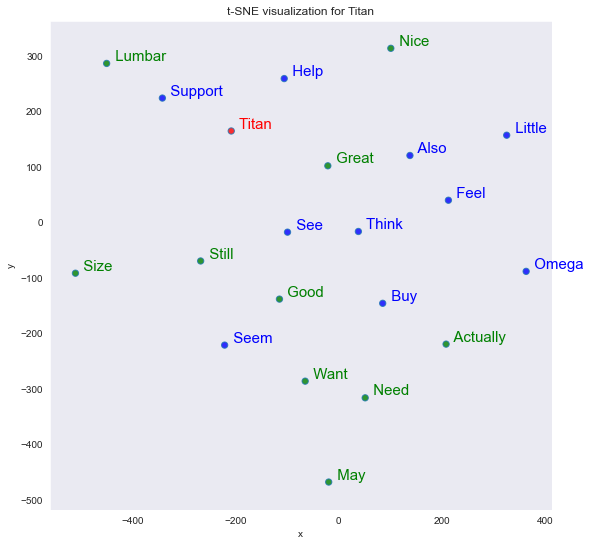

In [484]:
tsnescatterplot(w2v_model, "titan", [t[0] for t in w2v_model.wv.most_similar(positive=["titan"], topn=20)][10:])

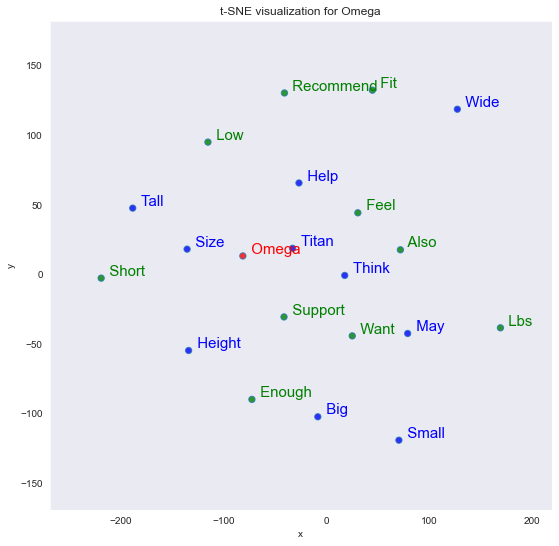

In [491]:
tsnescatterplot(w2v_model, "omega", [t[0] for t in w2v_model.wv.most_similar(positive=["omega"], topn=20)][10:])

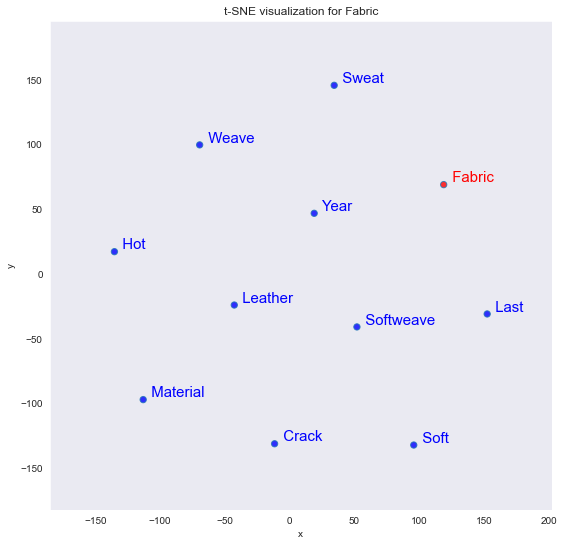

In [486]:
tsnescatterplot(w2v_model, "fabric", [])

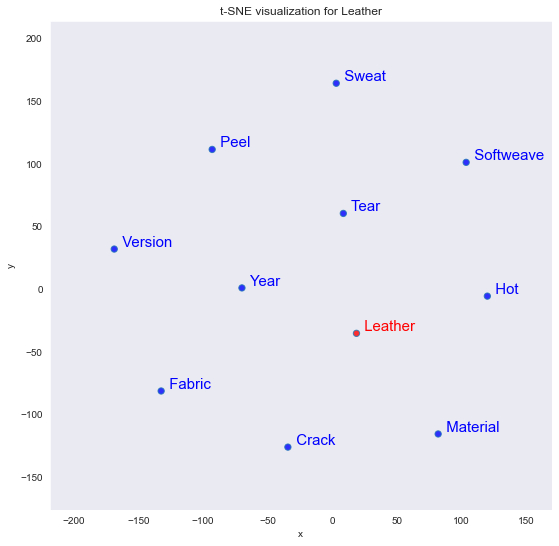

In [487]:
tsnescatterplot(w2v_model, "leather", [])

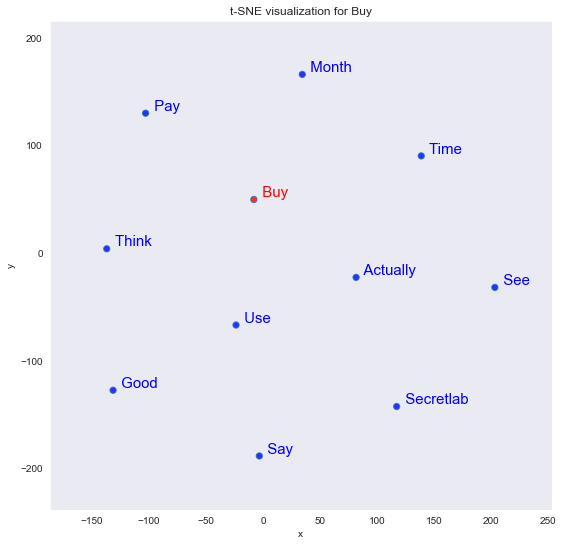

In [488]:
tsnescatterplot(w2v_model, "buy", [])

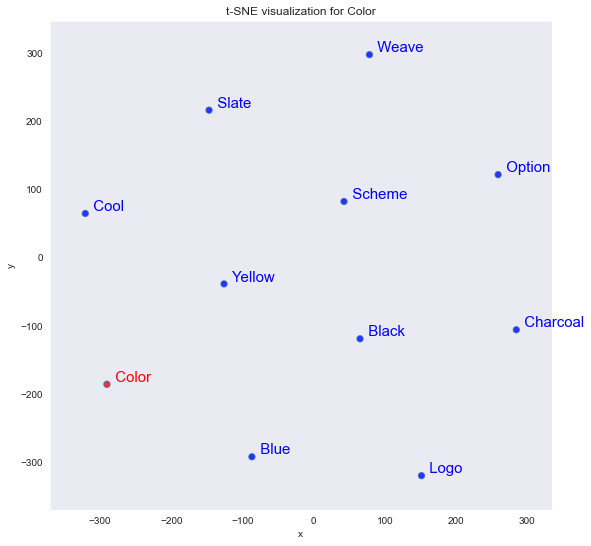

In [489]:
tsnescatterplot(w2v_model, "color", [])

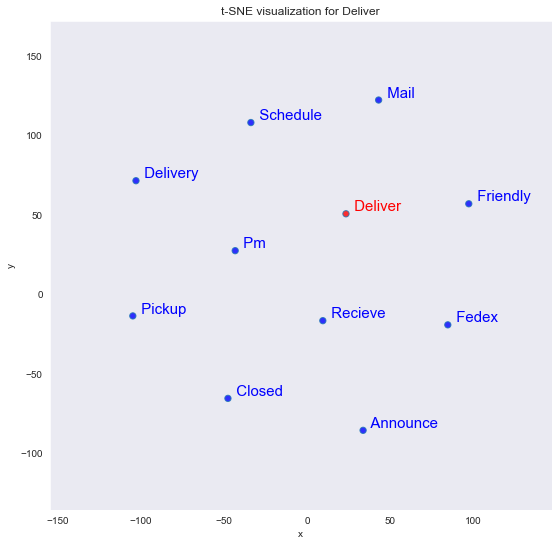

In [508]:
tsnescatterplot(w2v_model, "deliver", [])

# Time to do topic modelling

In [387]:
del data, data_ready, data_words, id2word, corpus

In [388]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)# remove single quotes
        sent = sent.replace("http","")
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = comments.comment.unique()
data_words = list(sent_to_words(data))
print(len(data_words),len(data))

9480 9480


In [389]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['cyberpunk','www','com','chair','game',
                   'video','much','really','review','thank','get'
                  ,'well','look','would','go','make','sit','chair'])

In [390]:
start_time = time.time()

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

data_ready = process_words(data_words)
print(len(data_ready))
print ("\ntotal time taken:",(time.time() - start_time)/60, "min")

9480

total time taken: 0.3552636663118998 min


In [391]:
# Explore if there are any other high frequency words that would prevent our LDA from distinguishing between topics

from collections import Counter

com_wds = [x for sublist in data_ready for x in sublist]

count = Counter(com_wds)
print(count.most_common()[:100])

[('buy', 1096), ('good', 1086), ('back', 855), ('use', 747), ('great', 730), ('omega', 674), ('think', 625), ('leather', 606), ('see', 596), ('year', 587), ('want', 572), ('say', 562), ('seat', 540), ('order', 506), ('love', 496), ('time', 493), ('support', 490), ('also', 487), ('feel', 461), ('titan', 433), ('know', 420), ('comfortable', 405), ('need', 393), ('still', 393), ('come', 390), ('work', 387), ('secret', 384), ('month', 377), ('people', 374), ('nice', 370), ('long', 362), ('day', 351), ('lab', 350), ('find', 344), ('even', 342), ('watch', 335), ('thing', 326), ('wait', 325), ('gaming', 308), ('help', 302), ('secretlab', 301), ('could', 299), ('way', 298), ('right', 287), ('new', 283), ('soft', 282), ('hard', 281), ('hour', 280), ('big', 276), ('try', 274), ('lumbar', 271), ('give', 269), ('keep', 269), ('rest', 265), ('lot', 258), ('may', 257), ('ever', 257), ('quality', 253), ('put', 251), ('take', 251), ('office', 250), ('price', 250), ('bad', 247), ('bit', 246), ('man', 2

In [392]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [393]:
start_time = time.time() 

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics=6,
                                                   random_state=42,
                                                   chunksize=6500,
                                                    update_every=1,
                                                   passes=50, 
                                                   alpha=0.01,
                                                   iterations=50,
                                                    eta=0.001,
                                                   per_word_topics=False)

coherencemodel = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')

print ("total time taken:",(time.time() - start_time)/60, "min")
print(coherencemodel.get_coherence())   
pprint(lda_model.print_topics())

total time taken: 2.3171432534853618 min
0.5990862718048062
[(0,
  '0.032*"back" + 0.016*"feel" + 0.012*"put" + 0.011*"side" + 0.010*"seat" + '
  '0.009*"firm" + 0.009*"use" + 0.008*"send" + 0.008*"hard" + 0.008*"hour"'),
 (1,
  '0.025*"year" + 0.018*"seat" + 0.011*"good" + 0.010*"time" + '
  '0.010*"warranty" + 0.009*"rest" + 0.009*"long" + 0.009*"old" + 0.009*"buy" '
  '+ 0.009*"use"'),
 (2,
  '0.052*"order" + 0.034*"wait" + 0.023*"leather" + 0.016*"soft" + '
  '0.015*"black" + 0.014*"fabric" + 0.013*"buy" + 0.013*"month" + 0.013*"come" '
  '+ 0.012*"weave"'),
 (3,
  '0.038*"great" + 0.030*"omega" + 0.021*"want" + 0.020*"love" + 0.017*"big" + '
  '0.017*"good" + 0.017*"tall" + 0.016*"titan" + 0.016*"think" + 0.015*"nice"'),
 (4,
  '0.029*"buy" + 0.024*"support" + 0.020*"use" + 0.017*"lumbar" + '
  '0.017*"gaming" + 0.013*"say" + 0.012*"office" + 0.012*"money" + '
  '0.011*"need" + 0.011*"think"'),
 (5,
  '0.049*"good" + 0.032*"ad" + 0.031*"secret" + 0.028*"lab" + 0.022*"see" + '
  '0

In [394]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
pyLDAvis.display(vis)

In [395]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data, tk=data_ready):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    tokens_text = pd.Series(tk)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df = pd.concat([sent_topics_df, tokens_text], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data, tk=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Token_tags']

In [396]:
pd.set_option('display.max_colwidth', 100)
df_dominant_topic.loc[(df_dominant_topic.Dominant_Topic == 3),["Keywords","Text"]][:20]

,Keywords,Text
1,"great, omega, want, love, big, good, tall, titan, think, nice",bro how did you carry the 400 pound chair into your house
5,"great, omega, want, love, big, good, tall, titan, think, nice",The editing meets a level of camp missing from tech and I appreciate.
33,"great, omega, want, love, big, good, tall, titan, think, nice",my american brain processed “400 pounds” and 400lb and was wondering why this small chair weighe...
49,"great, omega, want, love, big, good, tall, titan, think, nice","Why there are no more subs here, best reviews channels so far in 2020"
52,"great, omega, want, love, big, good, tall, titan, think, nice",All those icons in his desktop aggravate me lol
55,"great, omega, want, love, big, good, tall, titan, think, nice",I love your reviews! And the way you edit your videos.. thanks so much stu! Keep being awesome :)
75,"great, omega, want, love, big, good, tall, titan, think, nice","What is the narrowest inner measurement between the armrests on the Titan, please?"
86,"great, omega, want, love, big, good, tall, titan, think, nice",This felt so much like Topgear. Great edits and video presentation!
98,"great, omega, want, love, big, good, tall, titan, think, nice",I’m curious to know how tall you are? as I’m looking at buying this chair when I get the chance ...
115,"great, omega, want, love, big, good, tall, titan, think, nice",did productivity increase? or did you make more youtube shorts about the #secretlabs titan


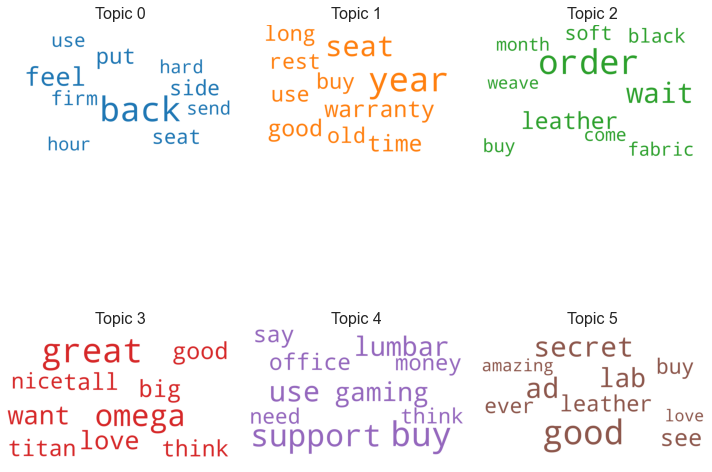

In [430]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2000,
                  height=1200,
                  max_words=12,
#                   colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2,3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0.9, hspace=0.9)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

|Topic #| Topic Meaning|
|-------|--------------|
|Topic 0|Firmness of the seat causing back issues|
|Topic 1|Discussion on how long the chair lasts for|
|Topic 2|Considering between Fabric and Leather|
|Topic 3|How great the Omega chair is|
|Topic 4|Whether the lumbar support is good|
|Topic 5|Compliments that the video help make a purchase decision|


## Tagged the documents with the topics generated by LDA

In [398]:
topics_df_6 = df_dominant_topic.copy()

In [400]:
topics_df_6.Dominant_Topic.value_counts(normalize=True)

0.0    0.222468
3.0    0.197574
4.0    0.165612
5.0    0.144620
2.0    0.135021
1.0    0.134705
Name: Dominant_Topic, dtype: float64

In [401]:
def tagged_document(list_of_list_of_words,df):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(words=list_of_words, tags=[int(df.Dominant_Topic[i])])

In [402]:
full_tagged_doc = list(tagged_document(data_ready, topics_df_6))
full_tagged_doc = utils.shuffle(full_tagged_doc)

In [403]:
train_doc = full_tagged_doc[:8500]
test_doc = full_tagged_doc[8500:]

len(train_doc), len(test_doc)

(8500, 980)

In [404]:
model_pvdm = gensim.models.Doc2Vec(vector_size=100, 
                                           dm_mean=1,
                                           window=4,
                                           negative=5,
                                           hs=0,
                                           sample=1e-5,
                                           seed=42,
                                           alpha=0.1,
                                           min_alpha=0.001,
                                           workers=6,
                                           dm=1)

In [405]:
model_pvdm.build_vocab(train_doc)

In [406]:
t = time.time()

model_pvdm.train(train_doc, total_examples=len(train_doc), epochs=1000)

print('Time to build Doc2Vec: {} min'.format(round((time.time() - t)/60, 2)))

Time to build Doc2Vec: 7.18 min


In [407]:
def vector_for_learning(model, input_docs):
    sents = input_docs
    targets, feature_vectors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, feature_vectors

# model_pvdm.save('secretlab.d2v')

# Train the 3 classifiers to predict the topic based on the weighted word vectors

In [408]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, plot_confusion_matrix, plot_precision_recall_curve

In [409]:
y_train, X_train = vector_for_learning(model_pvdm, train_doc)
y_test, X_test = vector_for_learning(model_pvdm, test_doc)

In [412]:
t = time.time()

# model = RandomForestClassifier(n_estimators=1000, random_state=42,max_depth=50,min_samples_leaf=2, n_jobs=6,criterion='entropy')
model = LogisticRegression(n_jobs=4, C=1, multi_class='multinomial',max_iter=20000,random_state=42,class_weight='balanced')
# model = SVC(C=1e5, class_weight='balanced', gamma='auto', kernel='poly',random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Time to train classifier: {} min'.format(round((time.time() - t)/60, 2)))
print()
print('Training accuracy %s' % model.score(X_train,y_train))
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print(f"MCC is {matthews_corrcoef(y_test, y_pred)}")

Time to train classifier: 0.02 min

Training accuracy 0.8608235294117647
Testing accuracy 0.6877551020408164
MCC is 0.6209094106871866


array([233, 137, 134, 198, 137, 141])


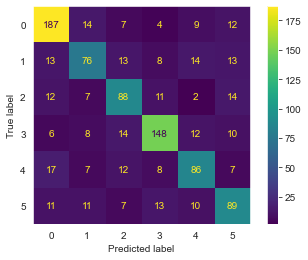

In [413]:
# 
plot_confusion_matrix(model,X_test,y_test);

y_c= list(y_test)
y_classes = np.array(y_c)
pprint(np.bincount(y_classes))

## We can explore the determinant words for one of the topic between the log reg classifier and the Doc2Vec model visually and statisically prove that they are correlated.

In [423]:
# vector from Doc2Vec model
dm_coef = model_pvdm.docvecs.doctag_syn0[3]
# vector from the Log Reg classifier
lr_coef = model.coef_[3]

print("Words determinant to Log Reg Classifier")
print("----"*10)
pprint(model_pvdm.similar_by_vector(lr_coef))
print()
print("Words determinant to Doc2Vec")
print("----"*10)
pprint(model_pvdm.similar_by_vector(dm_coef))

Words determinant to Log Reg Classifier
----------------------------------------
[('comfortably', 0.25152626633644104),
 ('bro', 0.23484185338020325),
 ('snug', 0.21710629761219025),
 ('originally', 0.20406052470207214),
 ('size', 0.2028352916240692),
 ('male', 0.19776876270771027),
 ('husband', 0.18971474468708038),
 ('tall', 0.187089204788208),
 ('chill', 0.18451052904129028),
 ('velcro', 0.1792258620262146)]

Words determinant to Doc2Vec
----------------------------------------
[('symbol', 0.36029061675071716),
 ('ft', 0.31007319688796997),
 ('bro', 0.30809274315834045),
 ('incredible', 0.2996496260166168),
 ('comfortably', 0.29147326946258545),
 ('snug', 0.2860320508480072),
 ('size', 0.2838527262210846),
 ('beginning', 0.27516692876815796),
 ('male', 0.26859986782073975),
 ('suggestion', 0.2587391138076782)]


In [424]:
coef, p = spearmanr(dm_coef, lr_coef)
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Determinant words are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Determinant words are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.854
Determinant words are correlated (reject H0) p=0.000


In [253]:
string_doc = "I've had this chair for many years now, and it still seem good"
cleaned_up = [word for word in simple_preprocess(string_doc) if word not in stop_words]
cleaned_up

['many', 'years', 'still', 'seem', 'good']

In [262]:
# vector = model_pvdm.infer_vector(["lumbar", "support","is", "good"])
vector = model_pvdm.infer_vector(cleaned_up)

In [263]:
model.predict_log_proba([vector])

array([[-5.04971435, -4.7334416 , -8.8366776 , -5.37620335, -1.53322465,
        -0.26894734]])

In [ ]:
# import pickle

# with open('full_tagged.pkl', 'wb') as f:
#     pickle.dump(full_tagged_doc, f)